# Figure 5- V2 animals are more motivated


In [2]:
import utils as u
import config as c
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, friedmanchisquare, wilcoxon, ks_2samp
import statsmodels.stats.multitest as smm
from itertools import combinations
import statsmodels.formula.api as smf
import itertools

sns.set_context("talk")
%load_ext autoreload
%autoreload 2

# Data Load


In [3]:
pdf = u.load_poke_df()

Loading poke data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication


# Utility Functions


In [4]:
"""Statistical Functions"""
def check_normality(data, alpha=0.05):
    """
    Returns True if data passes the Shapiro–Wilk test for normality
    at the specified alpha level, False otherwise.
    """
    stat, p = shapiro(data)
    return p >= alpha

def compare_two_groups(v1_values, v2_values, alpha=0.05):
    """
    Given two arrays of values (V1 and V2), checks normality in each group.
    If both pass, runs Welch's t-test. Otherwise, runs Mann–Whitney U.
    Returns a dict with test results.
    """
    normal_v1 = check_normality(v1_values, alpha=alpha)
    normal_v2 = check_normality(v2_values, alpha=alpha)

    results = {
        "normality_V1": normal_v1,
        "normality_V2": normal_v2,
        "n_V1": len(v1_values),
        "n_V2": len(v2_values),
    }

    if normal_v1 and normal_v2:
        # Use Welch’s t-test (two-sample, unequal variance)
        stat, p_val = ttest_ind(v1_values, v2_values, equal_var=False)
        results["test_type"] = "welch_t"
        results["test_statistic"] = stat
        results["p_val_raw"] = p_val
    else:
        # Use Mann–Whitney U for non-normal data
        stat, p_val = mannwhitneyu(v1_values, v2_values, alternative="two-sided")
        results["test_type"] = "mannwhitney"
        results["test_statistic"] = stat
        results["p_val_raw"] = p_val

    return results

def compare_v1_v2(df, metric_col, alpha=0.05):
    """
    Compare experimental groups V1 and V2 for data in a single stage.
    Assumes that the DataFrame `df` contains data for only one stage.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns:
            'fix_experiment' (with values 'V1' or 'V2')
            and the specified metric_col (the numeric variable to compare).
    metric_col : str
        The numeric variable to compare.
    alpha : float, optional
        Significance level for normality tests and final threshold (default 0.05).

    Returns
    -------
    pd.DataFrame
        A tidy DataFrame with a single row summarizing the test results.
    """
    # Extract data for V1 and V2
    v1_data = df.loc[df["fix_experiment"] == "V1", metric_col].to_numpy()
    v2_data = df.loc[df["fix_experiment"] == "V2", metric_col].to_numpy()

    # Compare the two groups
    result = compare_two_groups(v1_data, v2_data, alpha=alpha)
    
    # Return the result as a DataFrame with one row.
    result_df = pd.DataFrame([result])
    return result_df

def compare_v1_v2_multi_sample(df, metric_col, alpha=0.05):
    """
    Fit a mixed effects model to compare V1 and V2 for data in a single stage.
    Assumes that the DataFrame `df` contains data for only one stage.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns:
            'animal_id', 'fix_experiment' (with values 'V1' or 'V2'),
            and the specified metric_col (the numeric variable to compare).
    metric_col : str
        The numeric variable to compare.
    alpha : float, optional
        Significance level for the normality check of residuals (default 0.05).

    Returns
    -------
    pd.DataFrame
        A tidy DataFrame with a single row summarizing the mixed model test results.
    """
    required_cols = ["animal_id", "fix_experiment", metric_col]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"DataFrame is missing required column: '{col}'")

    # Ensure both groups exist in the data
    v1_df = df[df["fix_experiment"] == "V1"]
    v2_df = df[df["fix_experiment"] == "V2"]
    if v1_df.empty or v2_df.empty:
        raise ValueError("Both experimental groups (V1 and V2) must be present in the data.")

    # Fit the mixed effects model: metric_col ~ fix_experiment with a random intercept for animal_id
    model = smf.mixedlm(formula=f"{metric_col} ~ fix_experiment",
                        data=df,
                        groups=df["animal_id"])
    try:
        model_fit = model.fit(method="lbfgs", disp=False)
    except Exception as e:
        raise RuntimeError(f"Model fitting failed with error: {e}")

    coef_key = "fix_experiment[T.V2]"
    if coef_key not in model_fit.params.index:
        raise ValueError("Coefficient for fix_experiment[T.V2] not found in model fit.")

    t_val = model_fit.tvalues[coef_key]
    p_val = model_fit.pvalues[coef_key]

    # Check normality of the residuals from the model
    residuals = model_fit.resid
    residuals_are_normal = check_normality(residuals, alpha=alpha)

    result = {
        "test_type": "mixedlm_random_intercept",
        "test_statistic": t_val,
        "p_val_raw": p_val,
        "residuals_normal": residuals_are_normal,
    }
    result_df = pd.DataFrame([result])
    return result_df

In [5]:
""" Compute Violation Rate By Session Segment"""
def compute_violation_rates_by_session(df, pct):
    """
    Compute the violation rate for each session for three segments: early, middle, and late.
    
    Segments are defined as:
      - Early: first `pct` portion of trials,
      - Middle: middle `pct` portion of trials (centered at 0.5, i.e. from 0.5-pct/2 to 0.5+pct/2),
      - Late: last `pct` portion of trials.
    
    Parameters:
      df (pd.DataFrame): DataFrame with trial events for a session.
      pct (float): Proportion (between 0 and 0.5) that defines the size of each segment.
      
    Returns:
      pd.DataFrame: DataFrame with columns ['sessid', 'animal_id', 'date', 'fix_experiment',
                                             'segment', 'violation_rate'].
    """
    session_results = []
    group_cols = ['sessid', 'animal_id', 'date', 'fix_experiment']
    
    for name, group in df.groupby(group_cols):
        group = group.sort_index().copy()
        n_trials = len(group)
        
        # Create a normalized trial index (0 to 1)
        group['trial_norm'] = np.linspace(0, 1, n_trials, endpoint=False)
        
        # Define masks for each segment:
        early_mask = group['trial_norm'] < pct
        middle_mask = (group['trial_norm'] >= 0.5 - pct/2) & (group['trial_norm'] < 0.5 + pct/2)
        late_mask = group['trial_norm'] >= (1 - pct)
        
        # Create a new column for segment using np.select; trials not in any segment will be NaN.
        conditions = [early_mask, middle_mask, late_mask]
        choices = ['early', 'middle', 'late']
        group['segment'] = np.select(conditions, choices, default=pd.NA)
        
        # Keep only the trials that fall into one of the segments
        group_seg = group.dropna(subset=['segment'])
        
        # Compute the violation rate for each segment
        seg_rates = (group_seg.groupby('segment', observed=False)['was_violation']
                           .mean()
                           .reset_index(name='violation_rate'))
        
        # Add session identifiers
        seg_rates['sessid'] = name[0]
        seg_rates['animal_id'] = name[1]
        seg_rates['date'] = name[2]
        seg_rates['fix_experiment'] = name[3]
        
        session_results.append(seg_rates)
    
    result_df = pd.concat(session_results, ignore_index=True)
    return result_df



# A- Growth Stage (5-7) Violation Rates


In [6]:
vg_pdf = pdf.query("stage in @c.GROWING_STAGES").groupby(["animal_id", "fix_experiment", "date"]).agg({"was_valid": "mean"}).reset_index()
vg_pdf["violation_rate"] = (1 - vg_pdf["was_valid"]) * 100


In [7]:
vg_pdf.groupby(["animal_id", "fix_experiment", "date"]) \
    .agg(mean_violation_rate=("violation_rate", "mean")) \
    .reset_index() \
    .groupby(["fix_experiment"]) \
    .agg(mean_violation_rate=("mean_violation_rate", "mean"),
         std_violation_rate=("mean_violation_rate", "std"),
         n_sessions=("mean_violation_rate", "count")).reset_index()

,fix_experiment,mean_violation_rate,std_violation_rate,n_sessions
0,V1,21.815694,11.630556,237
1,V2,46.137770,16.429854,110


/Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication/utils.py:277: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=None, frameon=False)


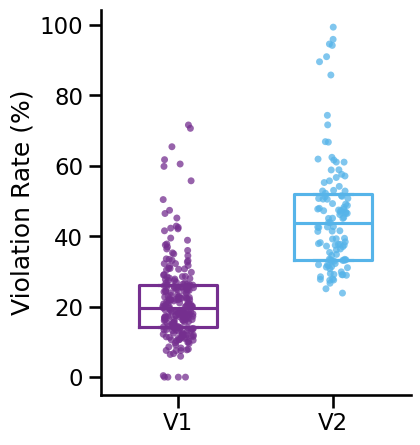

In [82]:
fig, ax = plt.subplots(figsize=(4,5))

u.box_strip_v1_vs_v2(vg_pdf, x="fix_experiment", order=c.HUE_ORDER_EXP, y="violation_rate", ax=ax, xlabel="", ylabel="Violation Rate (%)", dodge=False)

c.save_fig(fig, "fig4_viol_rates_growth_stages")


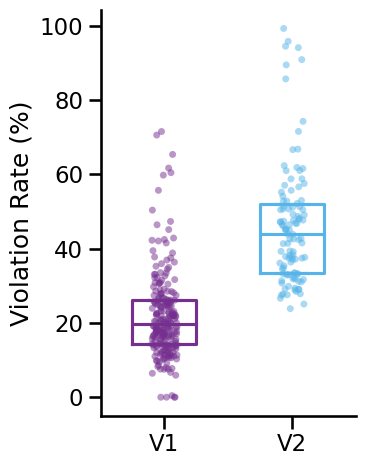

In [80]:
fig, ax = plt.subplots(figsize=(4,5))
x = "fix_experiment"
y="violation_rate"
order=c.HUE_ORDER_EXP
hue_type="experiment"

sns.despine()

sns.boxplot(
    x=x,
    y=y,
    data=vg_pdf,
    order=order,
    ax=ax,
    hue="fix_experiment",
    hue_order=["V1", "V2"],
    palette=c.EXP_PALETTE,
    fill=False,
    showfliers=False,
    whis=False,
    width=0.5,
)

if hue_type == "animal":
    hue = "animal_id"
    hue_order = c.HUE_ORDER_ANIMALS
    palette = c.ANIMAL_PALETTE
else:
    hue = "fix_experiment"
    hue_order = ["V1", "V2"]
    palette = c.EXP_PALETTE

sns.stripplot(
    x=x,
    y=y,
    data=vg_pdf,
    order=order,
    ax=ax,
    hue=hue,
    hue_order=hue_order,
    palette=palette,
    dodge=False,
    legend=False,
    alpha=0.5,
)
ax.set(
    ylabel="Violation Rate (%)",
    ylim=(None, None),
    xlabel="",
)
plt.tight_layout()

c.save_fig(fig, "fig4_viol_rates_growth_stages")


In [9]:

compare_v1_v2(vg_pdf, "violation_rate")
 

,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,False,False,237,110,mannwhitney,1977.5,4.787234e-37


In [10]:
compare_v1_v2_multi_sample(vg_pdf, "violation_rate")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


,test_type,test_statistic,p_val_raw,residuals_normal
0,mixedlm_random_intercept,7.343765,2.076678e-13,False


> Significant difference between V1 and V2 violation rates in growth stages


# B- N Attempted


In [11]:
tg_pdf = pdf.query("stage in @c.GROWING_STAGES") \
.groupby(["animal_id", "fix_experiment", "date"]) \
.agg(n_attempted=("animal_id", "size"), # each row is an attempted trial
     n_rewarded=("was_rewarded", "sum")).reset_index()
tg_pdf.head()

,animal_id,fix_experiment,date,n_attempted,n_rewarded
0,R040,V1,01-Aug-2024 14:28:29,440,320
1,R040,V1,02-Aug-2024 14:35:33,362,299
2,R040,V1,03-Aug-2024 14:05:41,421,352
3,R040,V1,04-Aug-2024 13:59:54,460,350
4,R040,V1,05-Aug-2024 13:59:14,382,301


In [12]:
tg_pdf.groupby("fix_experiment").agg(mean_n_attempted=("n_attempted", "mean"), std_n_attempted=("n_attempted", "std")).reset_index()

,fix_experiment,mean_n_attempted,std_n_attempted
0,V1,332.177215,109.616948
1,V2,470.200000,183.848352


/Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication/utils.py:277: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=None, frameon=False)


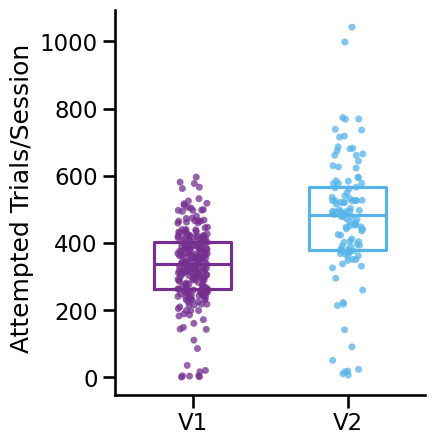

In [13]:
fig, ax = plt.subplots(figsize=(4,5))

u.box_strip_v1_vs_v2(tg_pdf, x="fix_experiment", order=c.HUE_ORDER_EXP, y="n_attempted", ax=ax, xlabel="", ylabel=" Attempted Trials/Session", dodge=False)


c.save_fig(fig, "fig4_n_attempted_growth_stages")

In [14]:
compare_v1_v2(tg_pdf, "n_attempted")

,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,False,False,237,110,mannwhitney,5689.0,2.961537e-17


In [15]:
compare_v1_v2_multi_sample(tg_pdf, "n_attempted")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


,test_type,test_statistic,p_val_raw,residuals_normal
0,mixedlm_random_intercept,3.323713,0.000888,False


> Significant difference between V1 and V2 attempted trials in growth stages


# C- N Rewarded


In [16]:
tg_pdf.groupby("fix_experiment").agg(mean_n_rewarded=("n_rewarded", "mean"), std_n_rewarded=("n_rewarded", "std")).reset_index()

,fix_experiment,mean_n_rewarded,std_n_rewarded
0,V1,246.632911,80.173463
1,V2,252.390909,110.042869


/Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication/utils.py:277: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=None, frameon=False)


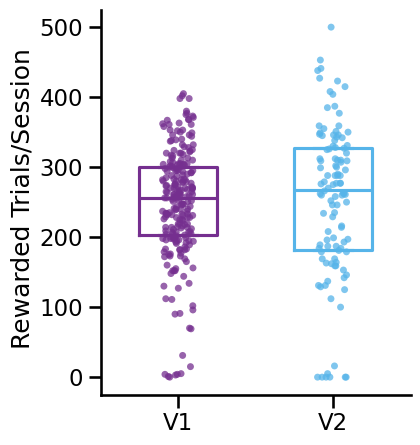

In [17]:
fig, ax = plt.subplots(figsize=(4,5))

u.box_strip_v1_vs_v2(tg_pdf, x="fix_experiment", order=c.HUE_ORDER_EXP, y="n_rewarded", ax=ax, xlabel="", ylabel=" Rewarded Trials/Session", dodge=False)

c.save_fig(fig, "fig4_n_rewarded_growth_stages")

In [18]:
compare_v1_v2(tg_pdf, "n_rewarded")

,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,False,False,237,110,mannwhitney,12258.5,0.372132


In [19]:
compare_v1_v2_multi_sample(tg_pdf, "n_rewarded")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


,test_type,test_statistic,p_val_raw,residuals_normal
0,mixedlm_random_intercept,0.419007,0.675211,False


> No significant difference between V1 and V2 rewarded trials in growth stages


> Results are not normal, so we will use a non-parametric test


# Trial Initiation Time Analysis

## Growth Stages


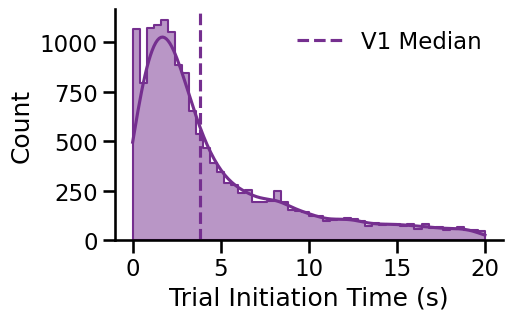

In [79]:
sns.set_context("talk")
MAX_ITI = 20
g__v1_iti_pdf = pdf.query("stage in @c.GROWING_STAGES and prev_was_valid==False and fix_experiment == 'V1'")
color = c.V1_COLOR

fig, ax = plt.subplots(figsize=(5,3))
sns.despine()
sns.histplot(
    data=g__v1_iti_pdf.query("cpoke_iti_adjusted < @MAX_ITI"),
    x="cpoke_iti_adjusted",
    ax=ax,
    kde=True,
    color=color,
    element="step",
)

ax.set(
    xlabel="Trial Initiation Time (s)",
)

median = g__v1_iti_pdf.cpoke_iti_adjusted.median()
ax.axvline(median, color=c.V1_COLOR, linestyle='--', label=f'V1 Median')


# Add legend to the plot without a frame
ax.legend(title="", frameon=False)
ax.get_legend().set_title("")
c.save_fig(fig, "fig4_growth_post_violation_iti_v1")


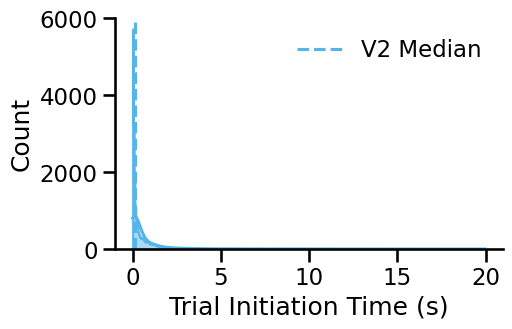

In [78]:

g__v2_iti_pdf = pdf.query("stage in @c.GROWING_STAGES and prev_was_valid==False and fix_experiment == 'V2'")
color = c.V2_COLOR

fig, ax = plt.subplots(figsize=(5,3))
sns.despine()
sns.histplot(
    data=g__v2_iti_pdf.query("cpoke_iti_adjusted < @MAX_ITI"),
    x="cpoke_iti_adjusted",
    ax=ax,
    color=color,
    kde=True,
    element="step",
)

ax.set(
    xlabel="Trial Initiation Time (s)",
)

median = g__v2_iti_pdf.cpoke_iti_adjusted.median()
ax.axvline(median, color=color, linestyle='--', label=f'V2 Median')


# Add legend to the plot without a frame
ax.legend(title="", frameon=False)
ax.get_legend().set_title("")
c.save_fig(fig, "fig4_growth_post_violation_iti_v2")


,median,mean,std,size
fix_experiment,,,,
V1,3.821095,16.608878,57.266243,17908
V2,0.149500,5.003430,52.926533,22622


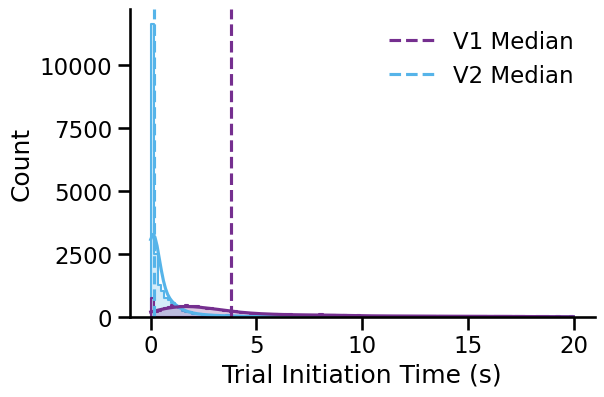

In [77]:
sns.set_context("talk")
MAX_ITI = 20
g_iti_pdf = pdf.query("stage in @c.GROWING_STAGES and prev_was_valid==False")

fig, ax = plt.subplots(figsize=(6,4))
sns.despine()
sns.histplot(
    data=g_iti_pdf.query("cpoke_iti_adjusted < @MAX_ITI"),
    x="cpoke_iti_adjusted",
    ax=ax,
    hue="fix_experiment",
    hue_order=c.HUE_ORDER_EXP,
    kde=True,
    element="step",
    palette =c.EXP_PALETTE,
)

ax.set(
    xlabel="Trial Initiation Time (s)",
)



# Calculate statistics for each fix_experiment
stats = g_iti_pdf.groupby('fix_experiment')['cpoke_iti_adjusted'].agg(['median', 'mean', 'std', 'size'])

# Print the statistics
(stats.reset_index())

# Plot median lines for each fix_experiment
for i, (exp, median) in enumerate(stats['median'].items()):
    ax.axvline(median, color=c.EXP_PALETTE[i], linestyle='--', label=f'{exp} Median')


# Add legend to the plot without a frame
ax.legend(title="", frameon=False)
ax.get_legend().set_title("")
c.save_fig(fig, "fig4_growth_post_violation_iti")

stats

In [27]:

# Suppose df_v1 and df_v2 are the subsets of your data
stat, pval = ks_2samp(g_iti_pdf.query("fix_experiment == 'V1'")['cpoke_iti_adjusted'], g_iti_pdf.query("fix_experiment == 'V2'")['cpoke_iti_adjusted'])
print(f"KS statistic={stat}, p={pval}")

KS statistic=0.6607296820956404, p=0.0


In [28]:
compare_v1_v2(g_iti_pdf.dropna(subset=["cpoke_iti_adjusted"]), metric_col="cpoke_iti_adjusted")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17716.
  res = hypotest_fun_out(*samples, **kwds)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22622.
  res = hypotest_fun_out(*samples, **kwds)


,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,False,False,17716,22622,mannwhitney,349967493.0,0.0


## Probe Stages


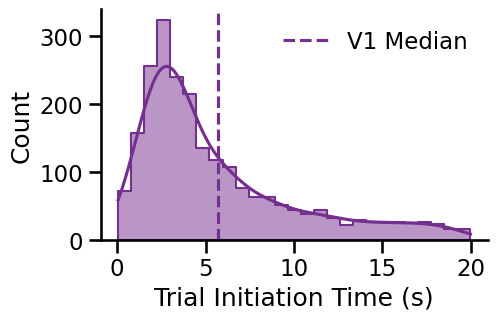

In [85]:
pr_v1_iti_pdf = pdf.query("stage in @c.PROBE_STAGES and prev_was_valid==False and fix_experiment == 'V1'")
color = c.V1_COLOR

fig, ax = plt.subplots(figsize=(5,3))
sns.despine()
sns.histplot(
    data=pr_v1_iti_pdf.query("cpoke_iti_adjusted_summed < @MAX_ITI"),
    x="cpoke_iti_adjusted_summed",
    ax=ax,
    kde=True,
    color=color,
    element="step",
)

ax.set(
    xlabel="Trial Initiation Time (s)",
)

median = pr_v1_iti_pdf.cpoke_iti_adjusted_summed.median()
ax.axvline(median, color=color, linestyle='--', label=f'V1 Median')


# Add legend to the plot without a frame
ax.legend(title="", frameon=False)
ax.get_legend().set_title("")
c.save_fig(fig, "fig4_probe_post_violation_iti_v1")


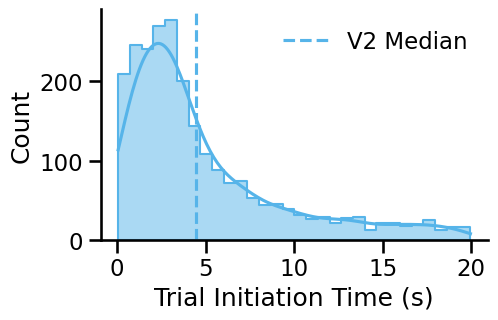

In [86]:
sns.set_context
MAX_ITI = 20
pr_v2_iti_pdf = pdf.query("stage in @c.PROBE_STAGES and prev_was_valid==False and fix_experiment == 'V2'")
color = c.V2_COLOR

fig, ax = plt.subplots(figsize=(5,3))
sns.despine()
sns.histplot(
    data=pr_v2_iti_pdf.query("cpoke_iti_adjusted_summed < @MAX_ITI"),
    x="cpoke_iti_adjusted_summed",
    ax=ax,
    kde=True,
    color=color,
    element="step",
)

ax.set(
    xlabel="Trial Initiation Time (s)",
)

median = pr_v2_iti_pdf.cpoke_iti_adjusted_summed.median()
ax.axvline(median, color=color, linestyle='--', label=f'V2 Median')


# Add legend to the plot without a frame
ax.legend(title="", frameon=False)
ax.get_legend().set_title("")
c.save_fig(fig, "fig4_probe_post_violation_iti_v2")


,median,mean,std,size
fix_experiment,,,,
V1,5.700289,22.964807,58.723832,2960
V2,4.471787,23.489020,66.879285,3095


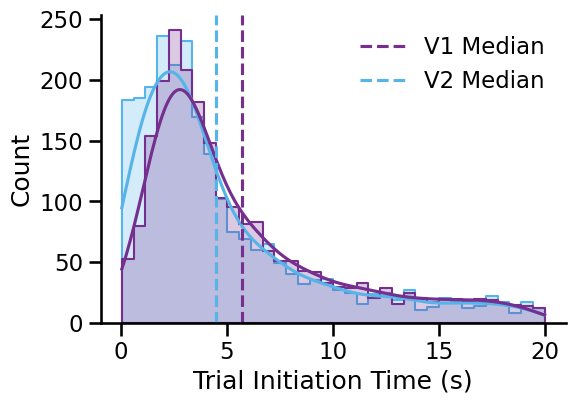

In [70]:
pr_iti_pdf = pdf.query("stage in @c.PROBE_STAGES and prev_was_valid==False")

fig, ax = plt.subplots(figsize=(6,4))
sns.despine()
sns.histplot(
    data=pr_iti_pdf.query("cpoke_iti_adjusted_summed < @MAX_ITI"),
    x="cpoke_iti_adjusted_summed",
    ax=ax,
    hue="fix_experiment",
    hue_order=c.HUE_ORDER_EXP,
    kde=True,
    element="step",
    palette =c.EXP_PALETTE,
)

ax.set(
    xlabel="Trial Initiation Time (s)",
)

# Calculate statistics for each fix_experiment
stats = pr_iti_pdf.groupby('fix_experiment')['cpoke_iti_adjusted_summed'].agg(['median', 'mean', 'std', 'size'])

# Print the statistics
(stats.reset_index())

# Plot median lines for each fix_experiment
for i, (exp, median) in enumerate(stats['median'].items()):
    ax.axvline(median, color=c.EXP_PALETTE[i], linestyle='--', label=f'{exp} Median')


# Add legend to the plot without a frame
ax.legend(title="", frameon=False)
ax.get_legend().set_title("")
c.save_fig(fig, "fig4_probe_post_violation_iti")

stats


In [71]:
# Suppose df_v1 and df_v2 are the subsets of your data
stat, pval = ks_2samp(pr_iti_pdf.query("fix_experiment == 'V1'")['cpoke_iti_adjusted_summed'], pr_iti_pdf.query("fix_experiment == 'V2'")['cpoke_iti_adjusted_summed'])
print(f"KS statistic={stat}, p={pval}")

KS statistic=0.09665818888355238, p=9.269859822319617e-13


In [61]:
compare_v1_v2(pr_iti_pdf, metric_col="cpoke_iti_adjusted_summed")

,normality_V1,normality_V2,n_V1,n_V2,test_type,test_statistic,p_val_raw
0,False,False,2960,3095,mannwhitney,5045802.0,7.827101e-12


# D- V2 Transition To Penalty On


In [62]:
pe_pdf = u.compute_days_relative_to_stage(pdf.query("fix_experiment == 'V2'").copy(), stage=8)
plot_df = pe_pdf[~((pe_pdf['settling_violation'] == 1) & (pe_pdf['days_relative_to_stage_8'] >= 0))] # remove settling in violations since they are not a true violation once in stage 8

# compute the violation rate (1- was_valid rate) for the day prior to and after the penalty on (stage 8) for each animal
pe_pdf = pe_pdf.query("days_relative_to_stage_8 >=-1 and days_relative_to_stage_8 <= 1") \
    .groupby(["animal_id", "fix_experiment", "days_relative_to_stage_8", "stage"]).agg({"was_valid": "mean"}).reset_index()
pe_pdf["violation_rate"] = (1 - pe_pdf["was_valid"]) * 100

pe_pdf.head()

,animal_id,fix_experiment,days_relative_to_stage_8,stage,was_valid,violation_rate
0,R041,V2,-1,7.0,0.488491,51.150895
1,R041,V2,0,8.0,0.808036,19.196429
2,R041,V2,1,9.0,0.658163,34.183673
3,R043,V2,-1,7.0,0.618343,38.165680
4,R043,V2,0,8.0,0.841727,15.827338


/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_65449/3886532432.py:6: UserWarning: 
The palette list has fewer values (1) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(


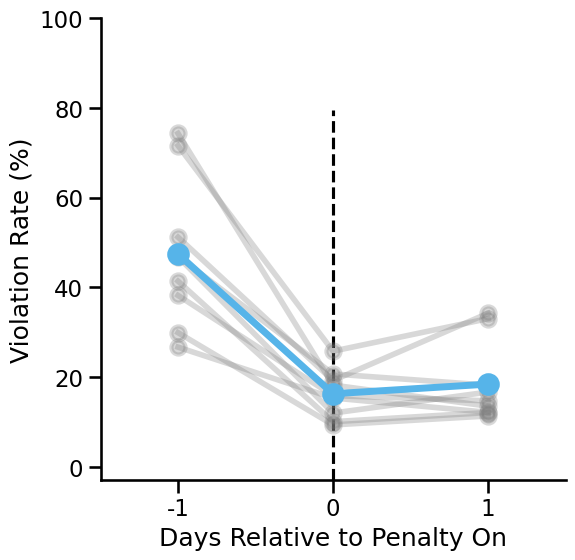

In [63]:
fig, ax = plt.subplots(figsize=(6,6))
sns.despine()
day_range = [-1, 1]

ax.axvline(x=1, color="k", ls = "--", ymax=0.8)
sns.pointplot(
    data=pe_pdf,
    x="days_relative_to_stage_8",
    y="violation_rate",
    hue="animal_id",
    palette=["gray"],
    ax=ax,
    alpha=0.3,
    legend=False
)
sns.pointplot(
    data=pe_pdf,
    x="days_relative_to_stage_8",
    y="violation_rate",
    color=c.V2_COLOR,
    ax=ax,
    errorbar=None,
    linewidth=5,  # make the line thicker
)


ax.set(
    ylabel="Violation Rate (%)",
    xlabel="Days Relative to Penalty On",
    ylim=(-3, 100),
)

c.save_fig(fig, "fig4_v2_penalty_on")

In [65]:
pe_pdf.groupby(["days_relative_to_stage_8"]).agg(mean_violation_rate=("violation_rate", "mean"), std_violation_rate=("violation_rate", "std")).reset_index()

,days_relative_to_stage_8,mean_violation_rate,std_violation_rate
0,-1,47.404437,16.513529
1,0,16.242829,5.346384
2,1,18.395364,8.900084


In [66]:
df_wide = pe_pdf.pivot(index='animal_id', columns='days_relative_to_stage_8', values='violation_rate')

# Check the pivoted data (optional)
print(df_wide)

# Perform the Friedman test. Ensure you order the columns appropriately.
stat, p_value = friedmanchisquare(df_wide[-1], df_wide[0], df_wide[1])
print(f"Friedman test statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Define the days to compare and perform pairwise Wilcoxon tests
days = [-1, 0, 1]
comparisons = list(itertools.combinations(days, 2))
alpha = 0.05
alpha_adjusted = alpha / len(comparisons)  # Bonferroni correction

for d1, d2 in comparisons:
    stat, p = wilcoxon(df_wide[d1], df_wide[d2])
    print(f"Comparison between day {d1} and day {d2}: Wilcoxon statistic = {stat:.4f}, p-value = {p:.4f} (adjusted α = {alpha_adjusted:.4f})")

days_relative_to_stage_8         -1          0          1
animal_id                                                
R041                      51.150895  19.196429  34.183673
R043                      38.165680  15.827338  14.673913
R045                      46.855984  20.663265  18.157182
R047                      29.866667   9.302326  11.295681
R049                      26.640159  15.306122  12.096774
R051                      41.347905  10.022272  12.063492
R053                      71.565495  25.742574  32.989691
R055                      74.280230  18.181818  13.475177
R057                      46.766917  11.943320  16.622691
Friedman test statistic: 13.5556
P-value: 0.0011
Comparison between day -1 and day 0: Wilcoxon statistic = 0.0000, p-value = 0.0039 (adjusted α = 0.0167)
Comparison between day -1 and day 1: Wilcoxon statistic = 0.0000, p-value = 0.0039 (adjusted α = 0.0167)
Comparison between day 0 and day 1: Wilcoxon statistic = 17.0000, p-value = 0.5703 (adjusted α = 0.0167